# Quantum Hall effect

In our project we are going to analyze the phenomenon of Hall conductivity
quantization in the so-called Hall bar structure. This effect is a clear manifestation of the quantized Landau levels creation for electrons in the presence of the
external magnetic field as well as the appearance of the so-called edge state.

<center><img src="systemORGINAL.png">

Firstly, we import essential libraries, like kwant, numpy and random, ect. 


In [1]:
import kwant
import numpy as np

from matplotlib import pyplot
import scipy.linalg as la
from math import atan2, pi, sqrt, exp
from scipy.constants import physical_constants
import random
from types import SimpleNamespace
from cmath import exp
from kwant . digest import uniform

from ipywidgets import interact

Defing some constants, like: Planck constant, electron mass, electron volt, elementary charge...

In [2]:
h_bar = physical_constants['Planck constant over 2 pi'][0]  
hh = physical_constants['Planck constant'][0]  
m_el = physical_constants['electron mass'][0]         
eV_unit = physical_constants['electron volt'][0]     
el_charge = physical_constants['elementary charge'][0]    
hh = physical_constants['Planck constant'][0]  

Division of the computational area into constant lattice (in 10nm distance) 

In [3]:
m_ef = 0.067 * m_el

a = 10                                   #lattice constant in nm 
a_unit = a * 10**(-9)                     #lattice constant in m
t_unit_J = h_bar**(2)/(2*m_ef*a_unit**2)  #in the units of J 
t = t_unit_J/eV_unit                      #in the units of eV; t - energy

We are defining the grey shape of computational area - shape_H and red lines which are leads (shape_lead...) in particular spots in the shape

In [4]:
def shape_H(pos):
    x,y = pos
    return (-60*a<=x<=60*a and -30*a<=y<=30*a) or (-49*a<=x<=-12*a and -70*a<=y<=70*a) or (12*a<=x<=49*a and -70*a<=y<=70*a)

We are creating leads (entrence and exits for electrons)

In [5]:
def shape_lead_middle(pos):
    x,y = pos
    return (-30*a<=y<=30*a)

def shape_lead_top(pos):
    x,y = pos
    return (40*a<=y<=70*a)

def shape_lead_bottom(pos):
    x,y = pos
    return (-70*a<=y<=-40*a)


Values of energies in various points in the area

In [6]:
def hopping(site_i, site_j, B):
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    phi = ((2*np.pi*B*el_charge)/hh)*10**-18
    return -t*exp(-0.5j * phi * (xi - xj) * (yi + yj))

Disturbances 

In [14]:
U0 = 0.0*t #the amplitude of the disorder potential
salt = 5 # how ”dense” thedisorderis
def onsite (site ):
    return U0 *(uniform(repr(site), repr(salt ))-0.5) + 4*t

We are building a system 

In [15]:
sys = kwant.Builder()
lat=kwant.lattice.square(a, norbs=1)

leadlm= kwant.Builder(kwant.TranslationalSymmetry((-a,0)))
leadlm[lat.shape(shape_lead_middle,(0,0))] = 4*t
leadlm[lat.neighbors()]=hopping

leadlt= kwant.Builder(kwant.TranslationalSymmetry((-a,0)))
leadlt[lat.shape(shape_lead_top,(0,60*a))] = 4*t
leadlt[lat.neighbors()]=hopping

leadlb= kwant.Builder(kwant.TranslationalSymmetry((-a,0)))
leadlb[lat.shape(shape_lead_bottom,(0,-60*a))] = 4*t
leadlb[lat.neighbors()]=hopping

leadrm = leadlm.reversed()
leadrt = leadlt.reversed()
leadrb = leadlb.reversed()

sys[lat.shape(shape_H,(0,0))] = onsite
sys[lat.neighbors()]=hopping

sys.attach_lead(leadlt) #upper left nr 0
sys.attach_lead(leadrt) #upper right nr 1
sys.attach_lead(leadlb) #bottom left nr 2
sys.attach_lead(leadrb) #bottom right nr 3
sys.attach_lead(leadlm) #middle left nr 4 
sys.attach_lead(leadrm) #middle right nr 5

sysf = sys.finalized()

We are ploting the system 

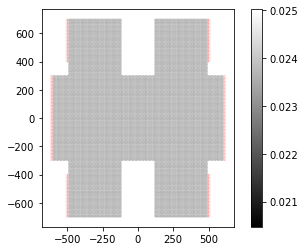

In [16]:
#kwant.plot(sysf);
kwant.plot(sysf, site_color=lambda site: sysf.hamiltonian(site,site, params=dict(U=U0)));

Computing values of conductance, sigmas for certain B value

<center><img src="systemShape.png">

1)Inner system visualization without any disturbances

2)With small disorder (U=0.1*t)

3)Bigger disorder (U=0.5*t) 

We calculate the conductance in the system to find values of voltages in the subsequent leads. 
Then we can calculate the longitudinal and Hall resistivity which we use to calculate sigmas XX and XY.

In [18]:
energy = 0.004                                   #we set the Fermi energy at 0.004 in the units of t
number = 70                                      #number of measurement points
Itab = [0,0,0,0,1]                               #array of currents
Btab = np.linspace(0.2,0.5,number)               #array of magnetic field
sigmaXX=np.zeros(number)                         #output array of sigmaXX
sigmaXY=np.zeros(number)                         #output array of sigmaXY


#calculation of transpose conductance matrix
def conductance(syst, ene, B):
    smatrix = kwant.smatrix (sysf, ene, params=dict(B=B))
    Gmat = np.transpose(smatrix.conductance_matrix ())
    return Gmat


for i in range (0,number):
    Vtab = np.zeros(5)                           #Vtab - vector of voltages
    Gmatrix = conductance(sysf, energy, Btab[i]) #conductance matrix
    Gmatrix_p = Gmatrix[:5 ,:5]                  #reduced conductance matrix 
    Gmatrix_inv = np.linalg.inv(Gmatrix_p)       #inverted reduced conductance matrix 
    Vtab = np.dot(Gmatrix_inv,Itab)             #product of conductance matrix and current matrix
    RL = Vtab[0]-Vtab[1]/Itab[4]                 #longitude 
    RH = Vtab[1]-Vtab[3]/Itab[4]                 #Hall resistivity
    sigmaXX[i] = RL/(RH**2+RL**2)
    sigmaXY[i] = RH/(RH**2+RL**2)
    print("i ",i," B = ",Btab[i]," sigmaXX = ", sigmaXX[i], "sigmaXY = ",sigmaXY[i])

i  0  B =  0.2  sigmaXX =  0.0004031643496921472 sigmaXY =  11.999689190401842
i  1  B =  0.20434782608695654  sigmaXX =  0.0011925423474995955 sigmaXY =  11.99886064581421
i  2  B =  0.20869565217391306  sigmaXX =  0.007675627934745228 sigmaXY =  11.974663640831366
i  3  B =  0.21304347826086958  sigmaXX =  9.499288772152071e-06 sigmaXY =  10.999994039578276
i  4  B =  0.2173913043478261  sigmaXX =  2.384752627917328e-06 sigmaXY =  10.999995955594638
i  5  B =  0.2217391304347826  sigmaXX =  1.6230683880393735e-06 sigmaXY =  10.999998020128343
i  6  B =  0.22608695652173916  sigmaXX =  3.936129167422921e-06 sigmaXY =  10.999993606672863
i  7  B =  0.23043478260869565  sigmaXX =  0.00040102602883213765 sigmaXY =  10.998125719897073
i  8  B =  0.23478260869565218  sigmaXX =  1.9790137537076683e-08 sigmaXY =  9.999999988083806
i  9  B =  0.2391304347826087  sigmaXX =  3.398190058669208e-09 sigmaXY =  9.999999994105094
i  10  B =  0.24347826086956523  sigmaXX =  1.5695930661955848e-09 sig

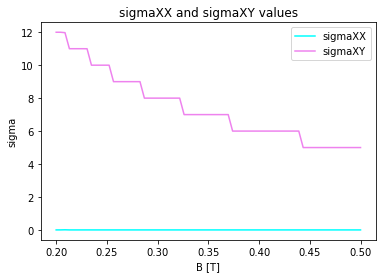

In [19]:
pyplot.title("sigmaXX and sigmaXY values")
pyplot.plot(Btab,sigmaXX, 'cyan', label="sigmaXX")
pyplot.plot(Btab,sigmaXY, 'violet',label="sigmaXY" )
pyplot.xlabel("B [T]")
pyplot.ylabel("sigma")
pyplot.legend(loc="upper right")

<center><img src="sigmasPlot.png">

'Stairs' are the effect of electrons jumping out of the area caused by decreasing Landau orbitals.
Sigma XY - describes boundary conditions (they correspond to the 'mustache' of the dispersion relationship)
Sigma XX - describes Laundau states (flattening of dispersion relations)

As field increase, dispersion relations become flatter and go up.
The longitudinal conductance peaks result from the fact that successive landau states formed in the magnetic field pass through the fermi energy as the field grows. 
Each time the state of the land passes through the fermi energies, we observe a peak.




For icreasing values of magnetic field (B) we observe:


1)No disturbamces: SigmaXX is flat, its values are near to 0 in the whole section; SigmaXY's values decrease rapidly, every few steps (that proces forms a stairs-shaped plot)

2)Mild disturbances: In points, where SigmaXY's values deacrese, we can observe peaks creation on the SigmaXX's plot. Despite the disorder, the shape of the SigmaXY plot is similar to the one without any disturbances.

3)Serious disturbances: The plots are more chaotic that in the previous cases. SigmaXY's values still decrease; earlier, after decrease, the value was maintaing certain value for some time; now after drop the value rises a little bit, but it's smaller than value before the drop. The relations between SigmaXY and SigmaXX goes with the similar scheme, like in previous simulations; the drop on the SigmaXY plot, the peak on the SigmaXX appear. But in this case SigmaXY plot is much more chaotic, so it affects SigmaXX plot; the peaks are more visible, they appear moreoften and  their values has increased.

Creating visualisation to display current density (gęstość prądu) for certain values of B in range 0.0 - 0.5 with step 0.1

In [22]:
energy = 0.004

def plot_wf(B=0):
    
    # we extract the wave function
    wfs = kwant.wave_function(sysf, energy=energy, params=dict(B=B))
    scattering_wf = wfs(4)  # all scattering wave functions from lead 2

    # plotting the probabiltiy density of particles flowing from lead 2
    kwant.plotter.map(sysf, np.sum(abs(scattering_wf)**2, axis=0));
    
    # calculating the current densityn
    J = kwant.operator.Current(sysf)
    current = sum(J(p, params=dict(B=B)) for p in scattering_wf)

    # plotting the current
    kwant.plotter.current(sysf, current)

    
interact(plot_wf, B=(0.0, 0.5, 0.1));

interactive(children=(FloatSlider(value=0.0, description='B', max=0.5), Output()), _dom_classes=('widget-inter…

<center><img src="CompPomiary.png">

System visualization without disorder

<center><img src="current densityBIG.png">

System visualization with disorder (U0 = 0.5 * t)

For the icreasing values of magnetic field (B) we observe Laurence force pushing electrons to the bottom of our system, moreover for 0.5 T (Tesla) we can see that electron injected in lead 4 (middle-left) are only capable to escape though nearest lead 2 (bottom left). Laurence force is too strong to allow electrons move freely in the system.

In general, disturbances cause more chaotic behavior of electrons.